In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_sheet
from peripodial.anisotropy import angle_distribution

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


Text(0, 0.5, 'D-V axis')

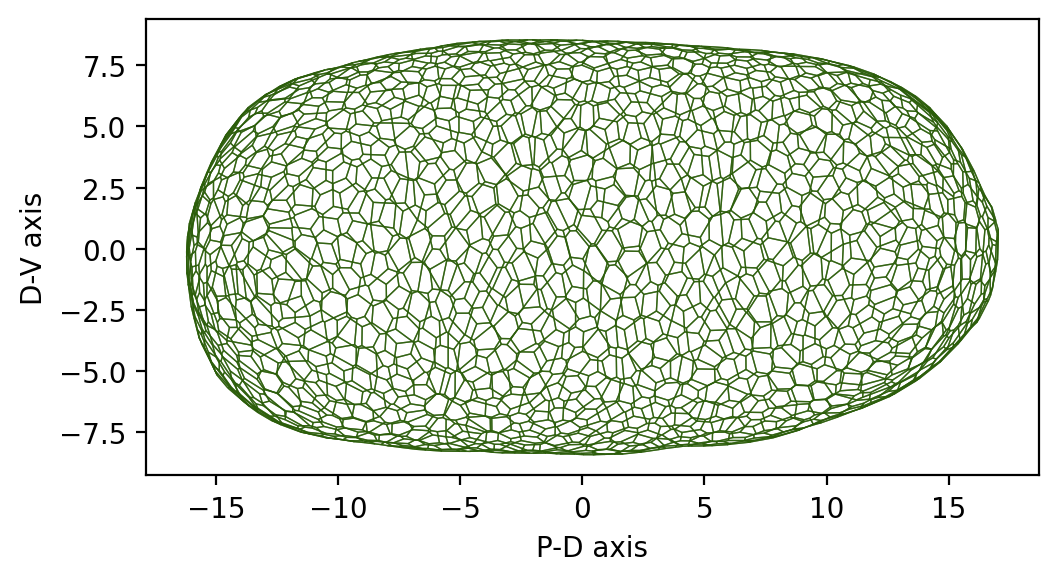

In [4]:
fig, ax = sheet_view(sheet, coords=["z", "x"])
ax.set_xlabel('P-D axis')
ax.set_ylabel('D-V axis')


In [5]:
sheet.face_df["area"].mean()

1.005847100697268

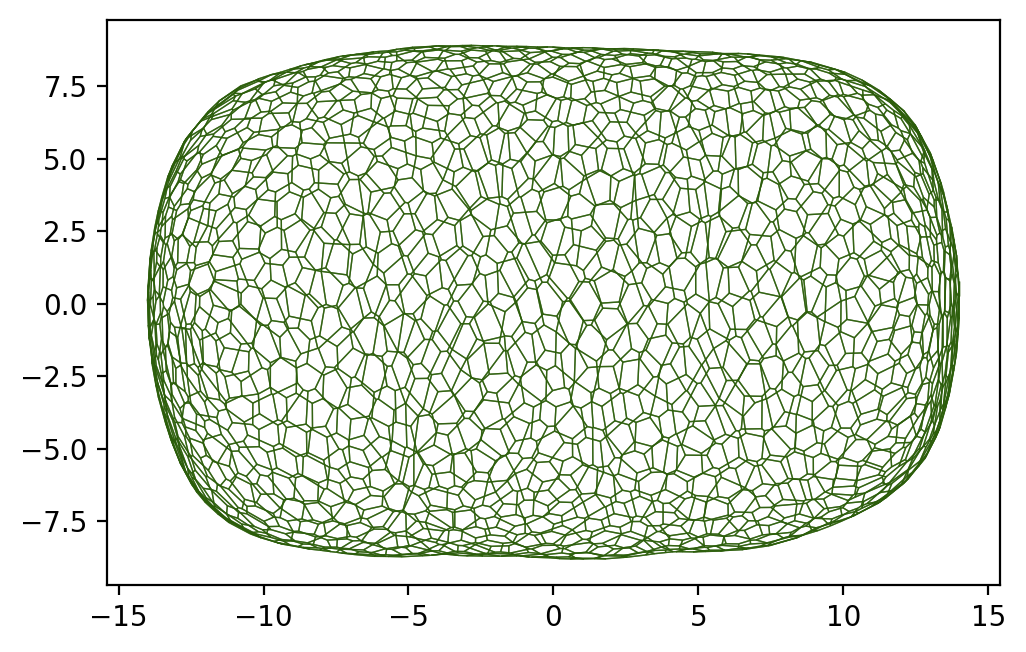

In [6]:
specs['settings']["barrier_radius"] = 14
sheet.update_specs(specs, reset=True)
solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
fig, ax = sheet_view(sheet, coords=["z", "x"])

In [7]:
#### verify that the function update_weight works
"""change = []
sheet_copy = sheet.copy()
theta = np.pi / 3

for i in range(10): 
    
    print(f"{i+1} / 10", end=" ")
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1.0,
    )
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)


sheet_copy1 = sheet_copy.copy()
sheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] 

draw_specs = {'vert': {
            'visible': False
            },
        'edge': {
            'color': sheet_copy1.edge_df["weight"],
            'colormap': "coolwarm",
            'width': sheet_copy1.edge_df["weight"]
            #'zorder': depth.values
            }
        }

fig, ax = sheet_view(sheet_copy1, ["z", "x"], mode='2D', **draw_specs)
ax.set_facecolor('#101010')
print(change)"""


'change = []\nsheet_copy = sheet.copy()\ntheta = np.pi / 3\n\nfor i in range(10): \n    \n    print(f"{i+1} / 10", end=" ")\n    z_orientation = update_weights(\n        sheet_copy, \n        threshold_angle=theta, \n        below_threshold=0.5,\n        above_threshold=1.0,\n    )\n    solver = QSSolver(with_t1=False, with_t3=False)\n    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})\n    change.append((z_orientation < np.sin(theta)**2).sum()  /sheet_copy.Ne)\n\n\nsheet_copy1 = sheet_copy.copy()\nsheet_copy1.edge_df = sheet_copy1.edge_df[sheet.edge_df["sy"] > 0] \n\ndraw_specs = {\'vert\': {\n            \'visible\': False\n            },\n        \'edge\': {\n            \'color\': sheet_copy1.edge_df["weight"],\n            \'colormap\': "coolwarm",\n            \'width\': sheet_copy1.edge_df["weight"]\n            #\'zorder\': depth.values\n            }\n        }\n\nfig, ax = sheet_view(sheet_copy1, ["z", "x"], mode=\'2D\', **draw_specs)\nax.set_fac

In [8]:
aniso(sheet, coords = ['x','y','z'])

face
0       0.155268
1       0.288155
2       0.247968
3       0.199909
4       0.293203
          ...   
1647    0.462070
1648    0.141225
1649    0.298177
1650    0.197065
1651    0.082119
Name: anisotropy, Length: 1652, dtype: float64

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


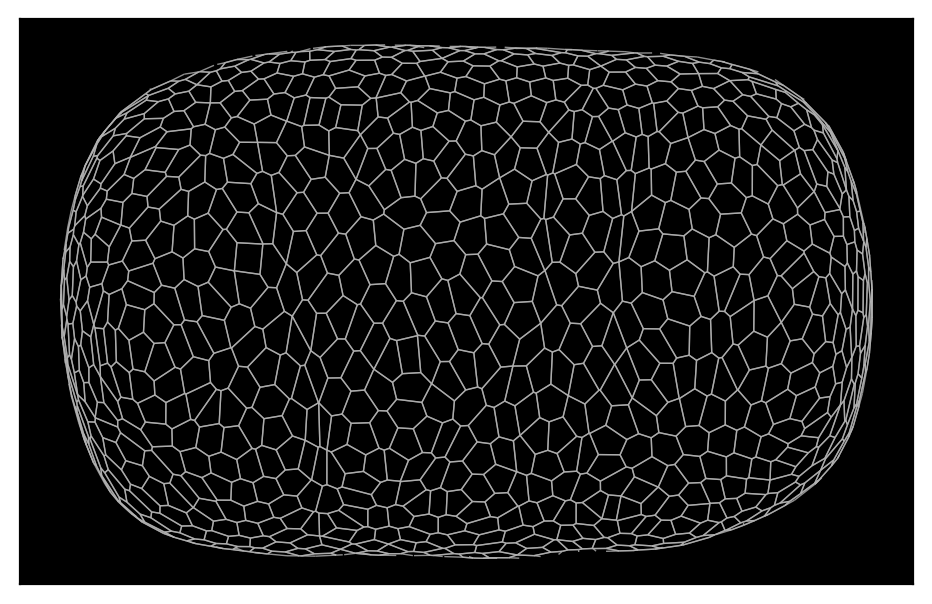

In [9]:
fig, ax = draw_half_sheet(sheet, ax=None)
ax.set_facecolor("black")

In [10]:
sheets_obj = {}
aniso_cell_values_d = []
angle_vs = []
theta = np.pi / 3
bts = np.arange(1, 0.3, -0.1)
angle_vs = []

for i, below_threshold in enumerate(bts):
    
    print(f"{i+1} / {7}", end=" ")
    z_orientation = update_weights(
        sheet, 
        threshold_angle=theta, 
        below_threshold=below_threshold,
        above_threshold=1,
    )
    geom.update_all(sheet)
    solver = QSSolver(with_t1=False, with_t3=False)
    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-4})
    angle_v = np.arcsin(z_orientation)
    angle_degrees = np.degrees(angle_v)
    sheet.face_df['anisotropy'] = aniso(sheet, coords = ['x','y','z'])
    center = np.abs(sheet.face_df["z"]) < sheet.face_df["z"].max()*0.75
    aniso_cell = sheet.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    angle_vs.append(angle_degrees)
    sheet_copy = sheet.copy()
    sheets_obj[below_threshold] = sheet_copy




print(angle_degrees)


1 / 7 2 / 7 3 / 7 4 / 7 5 / 7 6 / 7 7 / 7 edge
0       44.535953
1       88.840214
2       20.873582
3       65.606121
4       12.542631
          ...    
9895    40.579858
9896    56.389923
9897    56.389923
9898     3.934229
9899     3.934229
Length: 9900, dtype: float64


Il n'y a pas de différence significative entre les moyennes des deux populations.
Il n'y a pas de différence significative entre les moyennes des deux populations.
Il n'y a pas de différence significative entre les moyennes des deux populations.
Les variances entre les populations ne sont pas homogènes.


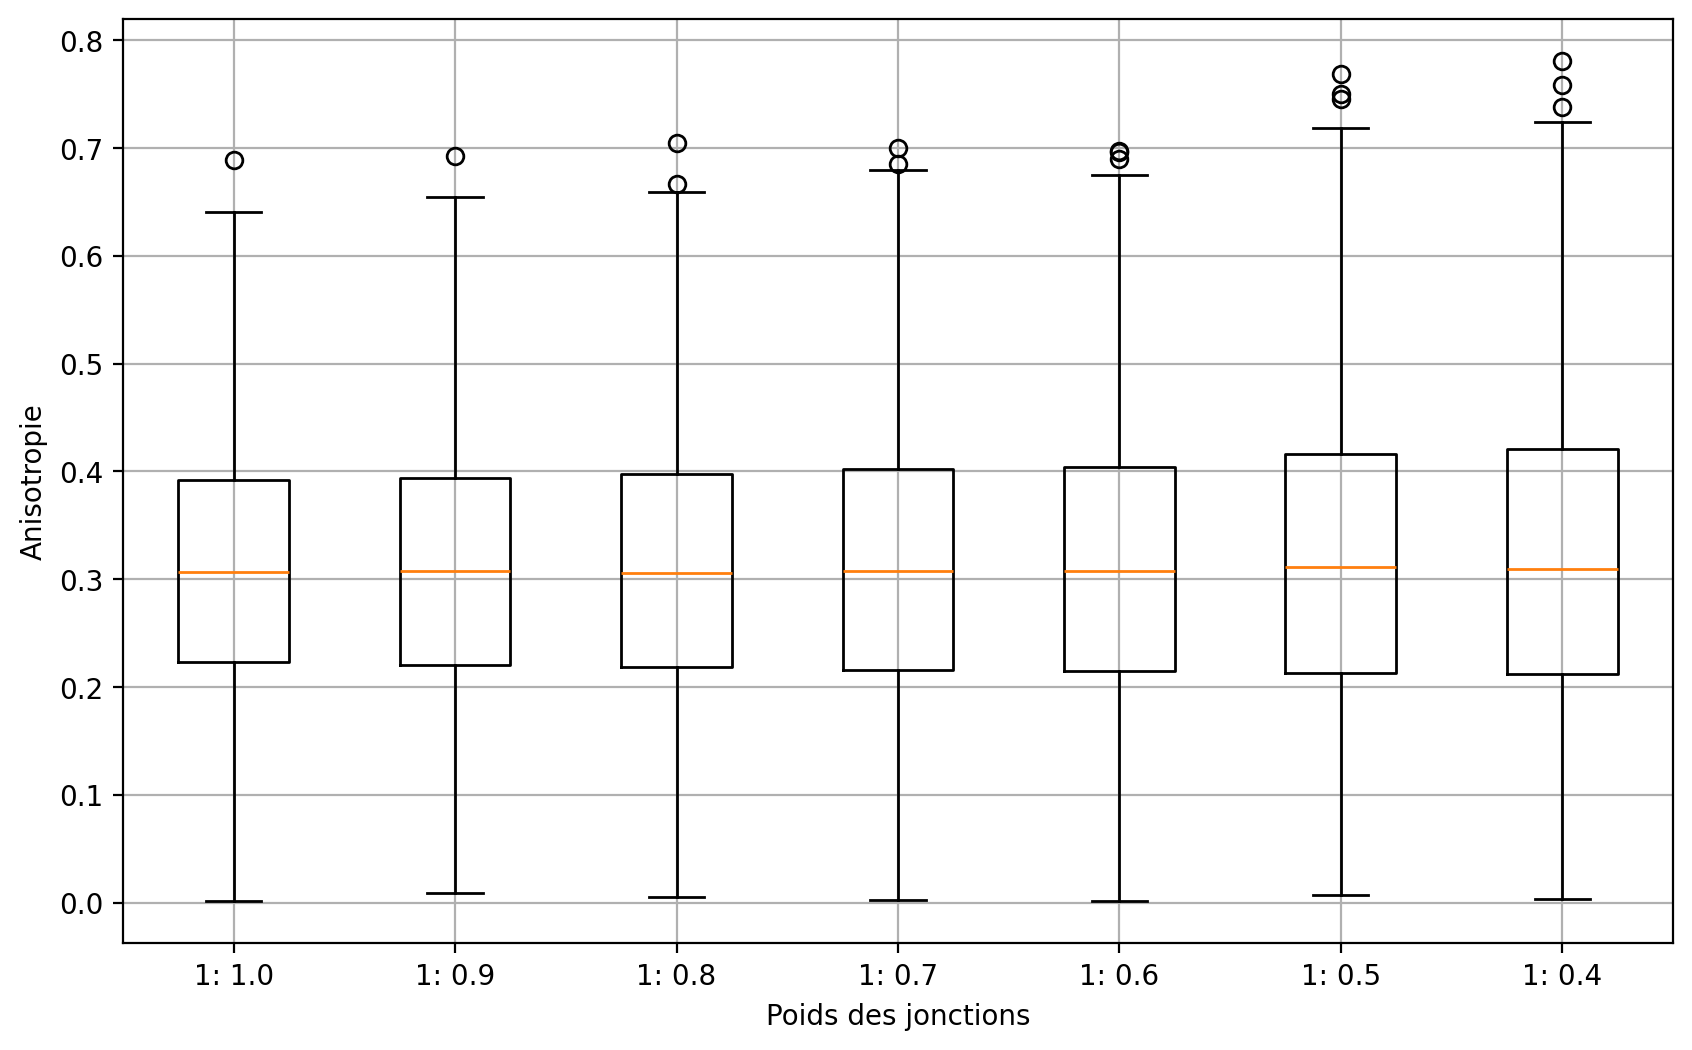

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, ttest_ind

# graphique
plt.figure(figsize=(10, 6))
bp = plt.boxplot(aniso_cell_values_d, patch_artist=False)
plt.xlabel('Poids des jonctions')
plt.ylabel('Anisotropie')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['1: {:.1f}'.format(i) for i in bts])
plt.grid(True)


#test t de student
statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[6])

# résultats test
if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1
    x_pos2 = 10
    y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i+1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')
        
statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[4])

# résultats test
if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1
    x_pos2 = 10
    y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i+1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')    

statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[2])

# résultats test
if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1
    x_pos2 = 10
    y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i+1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')

#test Levene pour vérifier l'homogénéité des variances
stat_levene, p_value_levene = levene(*aniso_cell_values_d)

if p_value_levene > 0.05:
    print("Les variances entre les populations sont homogènes.")
    # test ANOVA
    statistique, p_value_anova = f_oneway(aniso_cell_values_d[0], aniso_cell_values_d[-1])
    # résultats de l'ANOVA
    if p_value_anova > 0.05:
        print("Il n'y a pas de différence significative entre les moyennes des populations.")
    else:
        print("Il y a une différence significative entre les moyennes des populations.")
        for i in range(len(aniso_cell_values_d) - 1):
            x_pos1 = i+1
            x_pos2 = i+2
            y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i + 1])) + 0.05
            _, p_value_anova = f_oneway(aniso_cell_values_d[i], aniso_cell_values_d[9])

            # Placez le texte des étoiles en fonction de la position des barres
            if p_value_anova < 0.0001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
            elif p_value_anova < 0.001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
            elif p_value_anova < 0.01:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
            elif p_value_anova < 0.05:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')

else:
    print("Les variances entre les populations ne sont pas homogènes.")
plt.savefig('../image/plot_aniso_x_position.png', transparent=False)
plt.show()


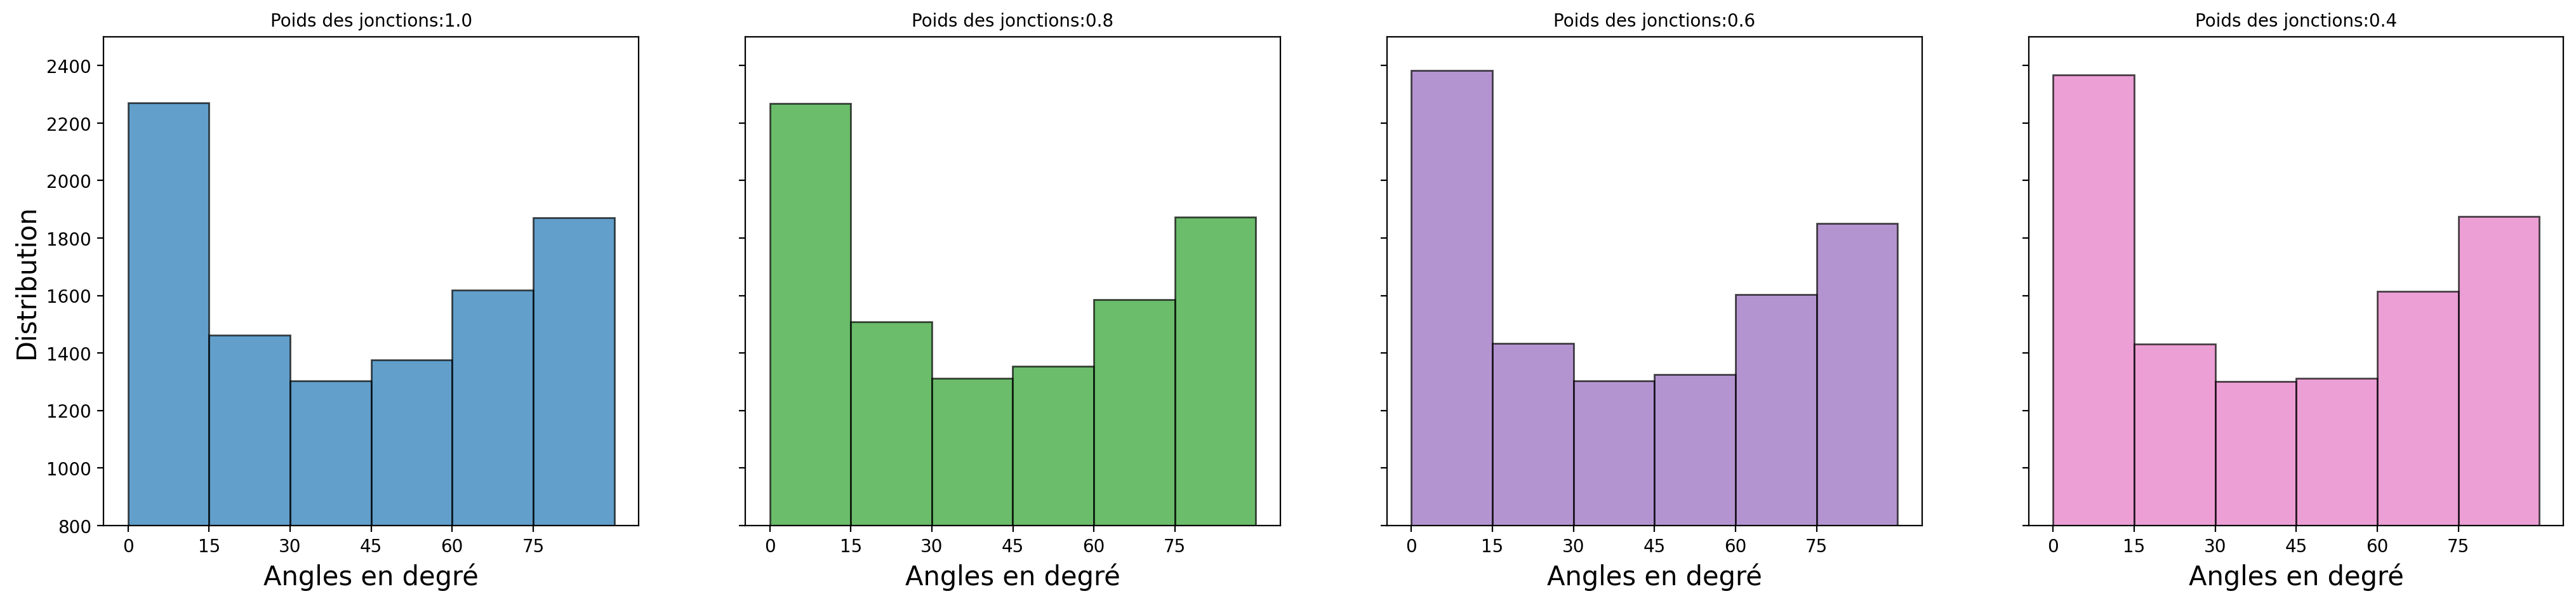

In [58]:
import matplotlib.pyplot as plt

# Création de la figure et des axes pour la moitié des objets
fig, axs = plt.subplots(1, (len(angle_vs) + 1) // 2, figsize=(4 * ((len(angle_vs) + 1) // 2), 2))

# Itérer sur les objets en prenant un sur deux
for i in range(0, len(angle_vs), 2):
    data = angle_vs[i]
    ax = axs[i // 2]
    ax.hist(data, bins=6, color='C{}'.format(i), alpha=0.7, edgecolor='black')
    ax.set_title('Poids des jonctions:{:.1f}'.format(bts[i]), fontsize=10)
    ax.set_ylim(800, 2500)
    ax.set_xticks(range(0, 90, 15))  # Ajoute des barres tous les 15 degrés
    ax.set_xlabel('Angles en degré', fontsize=15)

    if i == 0:  # Afficher les étiquettes des axes pour le premier subplot
        ax.set_ylabel('Distribution', fontsize=15)
    else:  # Masquer les étiquettes des axes y pour les autres subplots
        ax.set_yticklabels([])

# Ajustement de la taille de la figure
fig.set_size_inches(25, 5)
plt.savefig('../image/plot_distribution_angle.png', transparent=False)
plt.show()


In [ ]:
sheet.edge_df

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/draw/plt_draw.py:435: UserWarning: Attempting to draw a colormap with a uniform value
  warnings.warn("Attempting to draw a colormap " "with a uniform value")


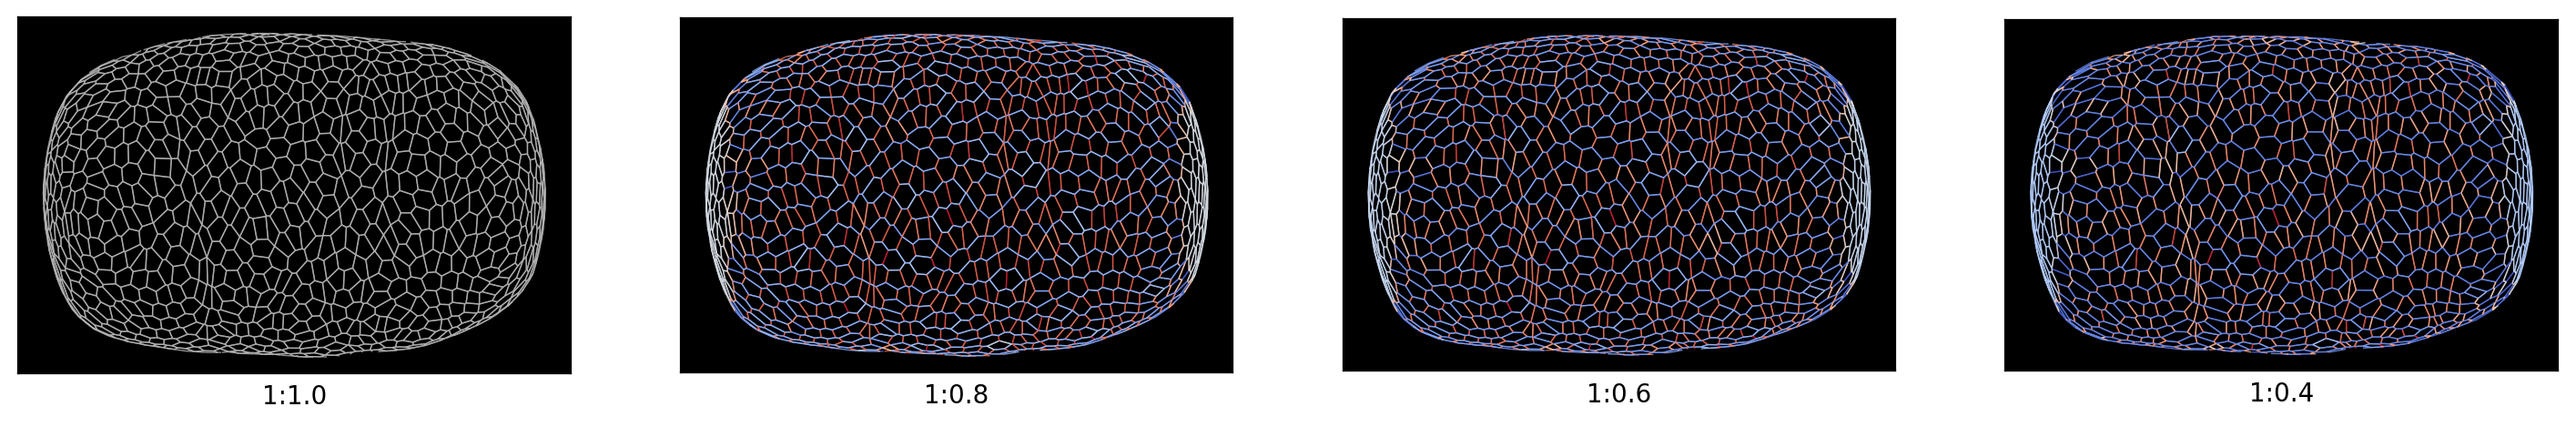

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, (len(sheets_obj) + 1) // 2, figsize=(28, 8))

for i, (above_threshold, sheet_copy) in enumerate(sheets_obj.items()):
    if i % 2 == 0: 
        ax = axes[i // 2]
        fig, ax = draw_half_sheet(sheet_copy, ax)
        ax.set_xlabel('1:{:.1f}'.format(bts[i]))
        ax.set_facecolor("black")

fig.set_size_inches(18, 5)
plt.savefig('../image/aniso_weight.png', transparent=False)
plt.show()



In [ ]:
"""from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/polarity.hdf5",sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/polarity.json", overwrite=True)"""